In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feat, adj_mat):
        num_neighbors = adj_mat.sum(dim = -1, keepdims=True)
        node_feat = self.projection(node_feat)
        node_feat = torch.bmm(adj_mat, node_feat)
        node_feat = node_feat / num_neighbors
        return node_feat

In [ ]:
import networkx as nx

nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

import matplotlib.pyplot as plt
fig = plt.figure()
nx.draw(nx_g, with_labels=True)

In [ ]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)

adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print(node_feats)

print(adj_matrix)

In [ ]:
layer = GCNLayer(c_in=2, c_out=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print(out_feats)

# GAT

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads = 1, concat_heads = True, alpha = 0.2) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads

        if self.concat_heads:
            assert c_out % num_heads == 0
            c_out = c_out // num_heads
        
        self.projection = nn.Linear(c_in, c_out*num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out))
        self.leakyrelu = nn.LeakyReLU(alpha)

        nn.init.xavier_uniform_(self.projection.weight.data, gain = 1.414)
        nn.init.xavier_uniform_(self.a.data, gain = 1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        edges = adj_matrix.nonzero(as_tuple = False)

        node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads, -1)

        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim = 0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim = 0)
        ], dim = -1)

        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        attn_probs = F.softmax(attn_matrix, dim = 2)
        if print_attn_probs:
            print(attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats


In [ ]:
layer = GATLayer(c_in=2, c_out=2, num_heads=2)

layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs = True)

print(out_feats)

# Pytorch Geometric

In [ ]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data

In [ ]:
import torch_geometric.datasets
from torch_geometric.transforms import NormalizeFeatures

dataset = torch_geometric.datasets.Planetoid(root='./data', name='Cora', transform=NormalizeFeatures())

In [ ]:
import numpy as np

data = dataset[0]
print(data['edge_index'])
print(data)

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_chan):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GCNConv(dataset.num_features, hidden_chan)
        self.conv2 = GCNConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_chan=16)
print(model)

In [ ]:
model = GCN(hidden_chan=16)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train(model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
test_acc = test()
print(test_acc)

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_chan, heads):
        super().__init__()
        torch.manual_seed(1123)
        self.conv1 = GATConv(dataset.num_features, hidden_chan)
        self.conv2 = GATConv(hidden_chan, dataset.num_classes)
    
    def forward(self, x, edge_index):
        print(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        raise Exception
        return x

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc
    
gatmodel = GAT(hidden_chan=8, heads=8)
optimizer = torch.optim.Adam(gatmodel.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(gatmodel)

In [ ]:
for epoch in range(1, 200):
    loss = train(gatmodel)
    val_acc = test(gatmodel, data.val_mask)
    test_acc = test(gatmodel, data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val; {val_acc:.4f}, \
          Test: {test_acc:.4f}')

In [ ]:
test_acc = test(gatmodel, mask=data.train_mask)
print(test_acc)

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())


In [ ]:
print(data['edge_index'])

In [ ]:
from torch_geometric.utils import degree

row, col = data['edge_index']
print(row, col)
deg = degree

### nodes
* ports
	* id
* vessels
	* id
	* fish		
	* maybe? location
	* label (one hot vector)
	* maybe? country
	* ask for information about vessel types		

### edges
* port
* ectr
	

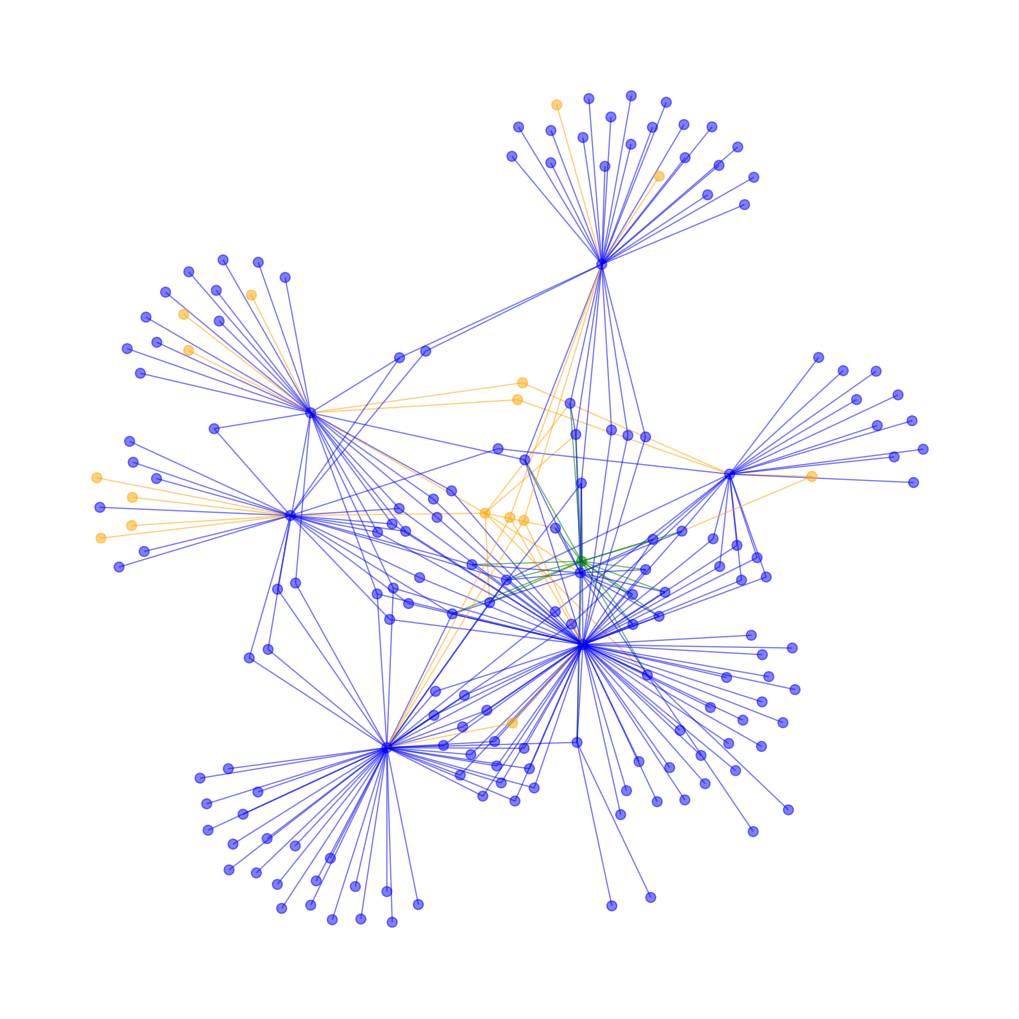

In [41]:
import networkx as nx
import pandas as pd
import numpy as np
import time

# nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

# import matplotlib.pyplot as plt
# fig = plt.figure()
# nx.draw(nx_g, with_labels=True)

data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

for ind, data in data_events.iterrows():
    init_vessel = data['vessel_id']
    sec_vessel = data['vessel_id2']
    port = data['port_id']
    event = data['event_type']

    G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
    n_colormap[init_vessel] = 'blue'
    
    # if not np.isnan(sec_vessel):
    if not np.isnan(sec_vessel):# and sec_vessel in feature_dict:
        if sec_vessel in feature_dict:
            label = feature_dict[sec_vessel]
            G.add_node(sec_vessel, name = 'vessel', label = label,
                       one_hot = eye[node_att_map[label]])
        else:
            G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                       one_hot = eye[node_att_map['NA']])

        G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
        n_colormap[sec_vessel] = 'blue'

    elif not np.isnan(port):
        G.add_node(port, name = 'port', label = 'Port',
                   one_hot = eye[node_att_map['Port']])
        G.add_edge(init_vessel, port, event = 'PORT', color = 'orange')
        n_colormap[port] = 'orange'
    
    else:
        G.add_edge(init_vessel, 0, event = event, color = 'green')
        n_colormap[0] = 'green'

G.nodes[0]['one_hot'] = eye[node_att_map['Fish']]

mapping = {node: ind for ind, node in enumerate(G.nodes)}
rev_map = {ind: node for ind, node in enumerate(G.nodes)}

H = nx.relabel_nodes(G, mapping, copy = True)

node_att = nx.get_node_attributes(H, 'one_hot')
edge_att = nx.get_edge_attributes(H, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed = 1123)
plt.figure(1, figsize=(10,10))
e_colors = [G[u][v]['color'] for u,v in G.edges()]
nx.draw(G, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.5, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

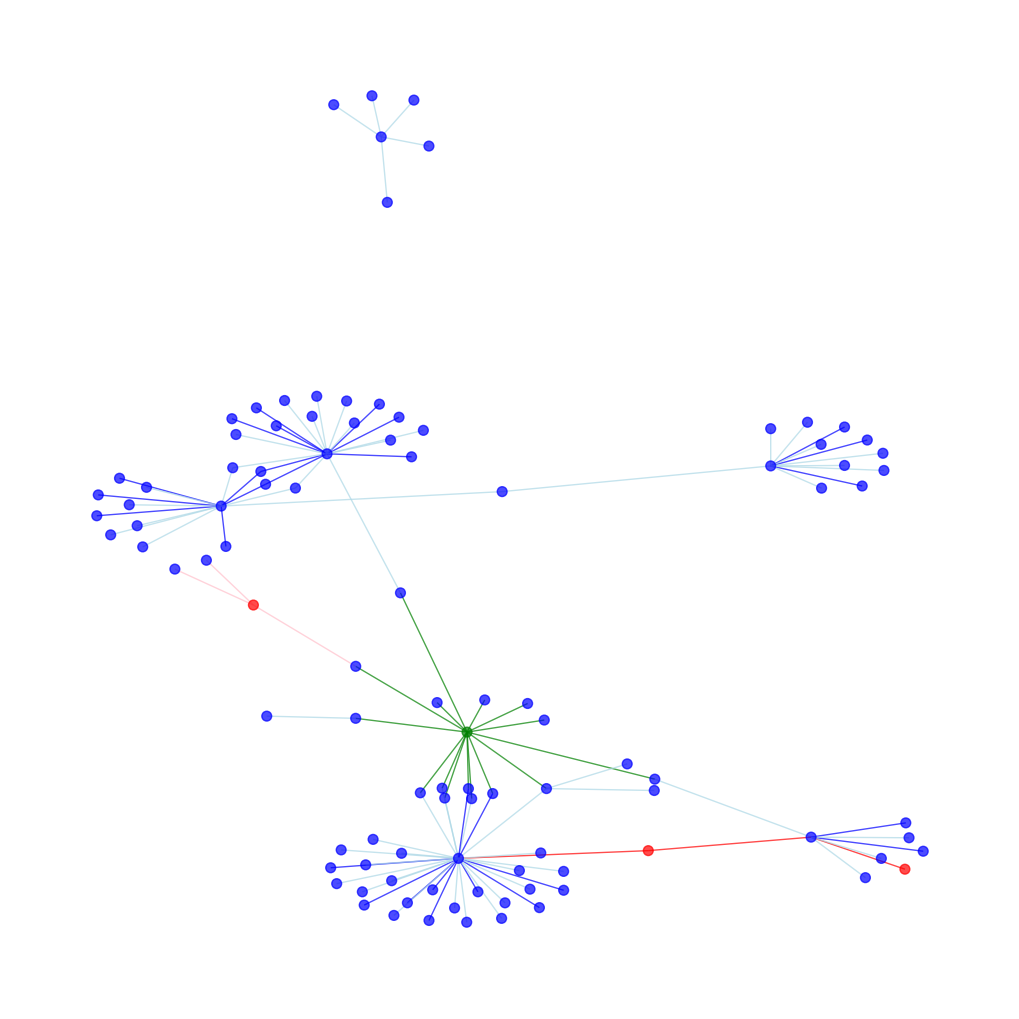

In [40]:
import networkx as nx
import pandas as pd
import numpy as np
import time

# nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

# import matplotlib.pyplot as plt
# fig = plt.figure()
# nx.draw(nx_g, with_labels=True)

data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

def add_to_g(path, G, right = True):
    data_events = pd.read_csv(path)
    for _, data in data_events.iterrows():
        init_vessel = data['vessel_id1']
        sec_vessel = data['vessel_id2']
        event = data['event_type']

        G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
        n_colormap[init_vessel] = 'blue'
        
        # if not np.isnan(sec_vessel):
        if event == 'ECTR':
            if sec_vessel in feature_dict:
                label = feature_dict[sec_vessel]
                G.add_node(sec_vessel, name = 'vessel', label = label,
                        one_hot = eye[node_att_map[label]])
            else:
                G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                        one_hot = eye[node_att_map['NA']])

            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightblue')
            n_colormap[sec_vessel] = 'blue'

        elif event == 'PORT':
            G.add_node(sec_vessel, name = 'port', label = 'Port',
                    one_hot = eye[node_att_map['Port']])
            
            if right:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'red')
            else:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'pink')
            n_colormap[sec_vessel] = 'red'
        
        else:
            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'green')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightgreen')
            n_colormap[0] = 'green'

path1 = 'res/right_data.csv'
add_to_g(path1, G, True)
path2 = 'res/wrong_data.csv'
add_to_g(path2, G, False)

G.nodes[0]['one_hot'] = eye[node_att_map['Fish']]

mapping = {node: ind for ind, node in enumerate(G.nodes)}
rev_map = {ind: node for ind, node in enumerate(G.nodes)}

H = nx.relabel_nodes(G, mapping, copy = True)

node_att = nx.get_node_attributes(H, 'one_hot')
edge_att = nx.get_edge_attributes(H, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed = 1123)
plt.figure(1, figsize=(10,10))
e_colors = [G[u][v]['color'] for u,v in G.edges()]
nx.draw(G, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.7, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

In [2]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import networkx as nx
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# Initialise inputs 
src = np.zeros((len(data_events)))
dst = np.zeros((len(data_events)))
t = np.zeros((len(data_events)))
# features = (lat_n,lat_s,lon_e,lon_w,ves1,ves2)
features = np.zeros((len(data_events), 4))
y = np.zeros((len(data_events), len(events)))

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.dayofyear

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')

for ind, data in data_events.iterrows():
    # Define source and dest array
    src[ind] = data['vessel_id']

    if not np.isnan(data['vessel_id2']):
        dst[ind] = data['vessel_id2']
    elif not np.isnan(data['port_id']):
        dst[ind] = data['port_id']
    else:
        dst[ind] = 0

    # Timestamp
    t[ind] = timesteps[ind]

    # Features
    features[ind] = np.array([data['lat_n'], data['lat_s'], data['lon_e'], data['lon_w']])

    # Even types
    event = data['event_type']
    y[ind][event_dict[event]] = 1

_, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
print(src)
print(dst)
src, dst = np.split(indexes, 2)
features = np.nan_to_num(features)

src = torch.Tensor(src).type(torch.long)
dst = torch.Tensor(dst).type(torch.long)
t = torch.Tensor(t).type(torch.long)
features = torch.Tensor(features)
y = torch.Tensor(y)

final_dataset = TemporalData(src, dst, t, features, y=y)

print(final_dataset)
print(features)
# _, uniq = np.unique(pd.concat((data_events['vessel_id'], data_events['vessel_id2'], data_events['port_id'])), return_inverse=True)
# print(indexes)
# print(uniq)
# print(np.array_equal(uniq, indexes))
# vals, counts = np.unique(dst, return_counts=True)
# print(counts)
# print(vals)

[3.52001165e+08 4.41098000e+08 4.40770000e+08 ... 3.52001165e+08
 5.38004149e+08 3.52001165e+08]
[4.12329429e+08 0.00000000e+00 0.00000000e+00 ... 4.40986000e+08
 4.40751000e+08 4.40772000e+08]
TemporalData(src=[2229], dst=[2229], t=[2229], msg=[2229, 4], y=[2229, 3])
tensor([[  -0.6426,   -0.6716,  159.1645,  159.1010],
        [  11.0267,   10.7133, -171.3326, -172.5636],
        [   4.0856,    3.9449,  177.3412,  176.5370],
        ...,
        [   3.5694,    3.5431,  179.7119,  179.6929],
        [  11.9641,   11.9366,  177.9725,  177.9508],
        [   3.5459,    3.5248,  179.6997,  179.6917]])


In [2]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import networkx as nx
import pandas as pd
import numpy as np
import copy
import scipy.sparse as sparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.day_of_year

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')
data_events['ectr_id'] = data_events['ectr_id'].astype('Int64')
data_events['vessel_id2'] = data_events['vessel_id2'].astype('Int64')
data_events

,Unnamed: 0,start_time,end_time,vessel_id,event_type,lat_n,lat_s,lon_e,lon_w,port_id,ectr_id,vessel_id2
0,0,2024-03-01 00:00:00,1/03/2024 1:42,352001165,ECTR,-0.642600,-0.671600,159.164500,159.101000,NaN,61112706,412329429
1,1300,2024-03-01 00:26:00,1/03/2024 20:29,441098000,FISH,11.026733,10.713332,-171.332633,-172.563567,NaN,<NA>,<NA>
2,364,2024-03-01 00:28:00,3/03/2024 0:49,440770000,FISH,4.085605,3.944897,177.341162,176.536997,NaN,<NA>,<NA>
3,467,2024-03-01 00:30:00,1/03/2024 17:48,440787000,FISH,11.382133,11.343050,178.499667,177.667450,NaN,<NA>,<NA>
4,1549,2024-03-01 00:52:00,2/03/2024 0:51,441650000,FISH,10.883613,10.744377,-174.449275,-175.234183,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
2224,34,2024-06-15 14:07:00,15/06/2024 17:13,352001165,ECTR,4.194800,4.174400,179.148500,179.122600,NaN,72596507,412209233
2225,1846,2024-06-16 00:11:00,16/06/2024 2:02,538004149,ECTR,11.997400,11.964500,177.998200,177.974900,NaN,72618924,441427000
2226,35,2024-06-16 00:21:00,16/06/2024 2:44,352001165,ECTR,3.569400,3.543100,179.711900,179.692900,NaN,72619177,440986000
2227,1847,2024-06-16 02:11:00,16/06/2024 3:56,538004149,ECTR,11.964100,11.936600,177.972500,177.950800,NaN,72622358,440751000


In [5]:
import pickle

with open('data/FB/adj_time_list.pickle', 'rb') as handle:
    adj_time_list = pickle.load(handle, encoding='latin1')

with open('data/FB/adj_orig_dense_list.pickle', 'rb') as handle:
    adj_orig_dense_list = pickle.load(handle, encoding='bytes')

print(adj_time_list)

print(adj_orig_dense_list)

[<663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 1688 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2344 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 3012 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 3476 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2836 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2560 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2676 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2666 stored elements in Compressed Sparse Row format>, <663x663 sparse matrix of type '<class 'numpy.uint8'>'
	with 2136 store

/tmp/ipykernel_3160372/2041084802.py:4: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  adj_time_list = pickle.load(handle, encoding='latin1')


In [65]:
from torch.autograd import Variable

x_in_list = []
for i in range(0, 3):
    x_temp = torch.tensor(np.eye(663).astype(np.float32))
    x_in_list.append(torch.tensor(x_temp))

x_in = Variable(torch.stack(x_in_list))
x_in[0]

h_dim = 32
x_dim = 663

phi_x = torch.nn.Sequential(torch.nn.Linear(x_dim, h_dim), torch.nn.ReLU())

/tmp/ipykernel_2754066/709429853.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in_list.append(torch.tensor(x_temp))


In [66]:
hu = phi_x(x_in[0])
print(hu.shape)

torch.Size([663, 32])


In [76]:
pd.unique(data_events['event_type'])
print(event_dict)
data_events.head(50)

{'FISH': 0, 'PORT': 1, 'ECTR': 2}


,Unnamed: 0,start_time,end_time,vessel_id,event_type,lat_n,lat_s,lon_e,lon_w,port_id,ectr_id,vessel_id2
0,0,2024-03-01 00:00:00,1/03/2024 1:42,352001165,ECTR,-0.642600,-0.671600,159.164500,159.101000,NaN,61112706,412329429
1,1300,2024-03-01 00:26:00,1/03/2024 20:29,441098000,FISH,11.026733,10.713332,-171.332633,-172.563567,NaN,<NA>,<NA>
2,364,2024-03-01 00:28:00,3/03/2024 0:49,440770000,FISH,4.085605,3.944897,177.341162,176.536997,NaN,<NA>,<NA>
3,467,2024-03-01 00:30:00,1/03/2024 17:48,440787000,FISH,11.382133,11.343050,178.499667,177.667450,NaN,<NA>,<NA>
4,1549,2024-03-01 00:52:00,2/03/2024 0:51,441650000,FISH,10.883613,10.744377,-174.449275,-175.234183,NaN,<NA>,<NA>
5,679,2024-03-01 01:27:00,1/03/2024 20:29,440885000,FISH,10.980017,10.903483,-174.853433,-175.648183,NaN,<NA>,<NA>
6,1216,2024-03-01 01:30:00,1/03/2024 21:29,440989000,FISH,11.366533,10.807950,-173.883800,-174.275267,NaN,<NA>,<NA>
7,1723,2024-03-01 02:17:00,1/03/2024 4:22,538004149,ECTR,12.158500,12.126500,-174.500500,-174.516700,NaN,61117881,440656000
8,1,2024-03-01 02:32:00,1/03/2024 4:04,352001165,ECTR,-0.684700,-0.705400,159.075200,159.034600,NaN,61119627,412329429
9,37,2024-03-01 02:42:00,1/03/2024 4:19,352002409,ECTR,10.564200,10.545500,178.552700,178.545100,NaN,61118451,440055000


In [7]:
adj_time_list = []
orig_list = []
all_feats = []
cur_date = timesteps[0]
ind_map = {}
rev_ind_map = {}

rows = []
cols = []
features = []
print(cur_date)

for ind, data in data_events.iterrows():
    # Get event
    event = data['event_type']

    # Append new vessel
    if data['vessel_id'] not in ind_map:
        rev_ind_map[len(ind_map)] = data['vessel_id']
        ind_map[data['vessel_id']] = len(ind_map)
        features.append([0, 0, 0])

    # Create new vessels / port depending on encounter type
    match event:
        case 'ECTR':
            if data['vessel_id2'] not in ind_map:
                rev_ind_map[len(ind_map)] = data['vessel_id2']
                ind_map[data['vessel_id2']] = len(ind_map)
                features.append([0, 0, 0])
        case 'PORT':
            if data['port_id'] not in ind_map:
                rev_ind_map[len(ind_map)] = data['port_id']
                ind_map[data['port_id']] = len(ind_map)
                features.append([0, 0, 0])
        case 'FISH':
            pass
    
    # Create the adj list
    if cur_date == timesteps[ind]:
        rows.append(ind_map[data['vessel_id']])
        features[ind_map[data['vessel_id']]][event_dict[event]] = 1

        match event:
            case 'ECTR':
                cols.append(ind_map[data['vessel_id2']])
                features[ind_map[data['vessel_id2']]][event_dict[event]] = 1
            case 'PORT':
                cols.append(ind_map[data['port_id']])
                features[ind_map[data['port_id']]][event_dict[event]] = 1
            case 'FISH':
                cols.append(ind_map[data['vessel_id']])
                features[ind_map[data['vessel_id']]][event_dict[event]] = 1
        
        # Change this to end of timestep
        if ind + 1 == len(timesteps):
            all_feats.append(copy.deepcopy(features))

            np_row = np.array(rows)
            np_cols = np.array(cols)
            ones = np.ones_like(np_row)

            mat = sparse.csr_matrix((ones, (np_row, np_cols)), shape=(len(features), len(features)))
            mat_dense = torch.Tensor(mat.todense())
            orig_list.append(mat_dense)
            adj_time_list.append(copy.deepcopy(mat))

    else:
        all_feats.append(copy.deepcopy(features))
        features = [[0, 0, 0] for _ in range(len(features))]

        np_row = np.array(rows)
        np_cols = np.array(cols)
        ones = np.ones_like(np_row)

        mat = sparse.csr_matrix((ones, (np_row, np_cols)), shape=(len(features), len(features)))
        mat_dense = torch.Tensor(mat.todense())
        orig_list.append(mat_dense)
        adj_time_list.append(copy.deepcopy(mat))

        rows = []
        cols = []
        cur_date = timesteps[ind]

        rows.append(ind_map[data['vessel_id']])
        features[ind_map[data['vessel_id']]][event_dict[event]] = 1

        match event:
            case 'ECTR':
                cols.append(ind_map[data['vessel_id2']])
                features[ind_map[data['vessel_id2']]][event_dict[event]] = 1
            case 'PORT':
                cols.append(ind_map[data['port_id']])
                features[ind_map[data['port_id']]][event_dict[event]] = 1
            case 'FISH':
                cols.append(ind_map[data['vessel_id']])
                features[ind_map[data['vessel_id']]][event_dict[event]] = 1


print(cur_date)
print(adj_time_list)
print(orig_list)
print(len(all_feats))

# _, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
# print(src)
# print(dst)
# src, dst = np.split(indexes, 2)
# features = np.nan_to_num(features)

# src = torch.Tensor(src).type(torch.long)
# dst = torch.Tensor(dst).type(torch.long)
# t = torch.Tensor(t).type(torch.long)
# features = torch.Tensor(features)
# y = torch.Tensor(y)

# final_dataset = TemporalData(src, dst, t, features, y=y)

# print(final_dataset)
# print(features)
# _, uniq = np.unique(pd.concat((data_events['vessel_id'], data_events['vessel_id2'], data_events['port_id'])), return_inverse=True)
# print(indexes)
# print(uniq)
# print(np.array_equal(uniq, indexes))
# vals, counts = np.unique(dst, return_counts=True)
# print(counts)
# print(vals)

61
168
[<19x19 sparse matrix of type '<class 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>, <25x25 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>, <29x29 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>, <31x31 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>, <32x32 sparse matrix of type '<class 'numpy.int64'>'
	with 15 stored elements in Compressed Sparse Row format>, <41x41 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>, <41x41 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>, <46x46 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>, <50x50 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in Compressed Spar

In [11]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])
c = np.array([9,10,11,12])

print(np.vstack((a, b, c)).T)

[[ 1  5  9]
 [ 2  6 10]
 [ 3  7 11]
 [ 4  8 12]]


In [ ]:
final_dataset = final_dataset.to(device)

train_data, val_data, test_data = final_dataset.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

neighbors = torch.empty((final_dataset.num_nodes, 10), dtype=torch.long)

neighbor_loader = LastNeighborLoader(final_dataset.num_nodes, size=10, device=device)

train1 = train_loader.__iter__().__next__()
print(train1)
#print(len(np.unique(train1['src'])) + len(np.unique(np.concatenate((train1['dst'], train1['neg_dst'])))))
print(train1['src'])
print(train1['dst'])
print(train1['t'])
print(train1['msg'])
print(train1['neg_dst'])
print(train1['n_id'])

In [ ]:
print(feature_dict)

In [ ]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.abspath(''), 'data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

print(dataset[0])
print(dataset[0]['y'])
print(dataset[0].num_nodes)

In [ ]:
train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

train1 = train_loader.__iter__().__next__()
print(train1)
print(len(np.unique(train1['src'])) + len(np.unique(np.concatenate((train1['dst'], train1['neg_dst'])))))
print(train1['src'])
print(train1['dst'])
print(train1['t'])
print(train1['msg'])
print(train1['neg_dst'])
print(train1['n_id'])

# Train TGN

This just predicts if a link would exist without considering the future time step specifically

In [40]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.

import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# Initialise inputs 
src = np.zeros((len(data_events)))
dst = np.zeros((len(data_events)))
t = np.zeros((len(data_events)))
# features = (lat_n,lat_s,lon_e,lon_w,ves1,ves2)
features = np.zeros((len(data_events), 4))
y = np.zeros((len(data_events), len(events)))

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.dayofyear

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')

for ind, data in data_events.iterrows():
    # Define source and dest array
    src[ind] = data['vessel_id']

    if not np.isnan(data['vessel_id2']):
        dst[ind] = data['vessel_id2']
    elif not np.isnan(data['port_id']):
        dst[ind] = data['port_id']
    else:
        dst[ind] = 0

    # Timestamp
    t[ind] = timesteps[ind]

    # Features
    features[ind] = np.array([data['lat_n'], data['lat_s'], data['lon_e'], data['lon_w']])

    # Even types
    event = data['event_type']
    y[ind][event_dict[event]] = 1

vals, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
src, dst = np.split(indexes, 2)
features = np.nan_to_num(features)

src = torch.Tensor(src).type(torch.long)
dst = torch.Tensor(dst).type(torch.long)
t = torch.Tensor(t).type(torch.long)
features = torch.Tensor(features)
y = torch.Tensor(y)

data = TemporalData(src=src, dst=dst, t=t, msg=features, y=y)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

class TimeEncoder(torch.nn.Module):
    def __init__(self, out_channels: int):
        super().__init__()
        self.out_channels = out_channels
        self.lin = Linear(1, out_channels)

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.lin(t.view(-1, 1)).cos()

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_time = Linear(in_channels, in_channels)
        self.time_enc = TimeEncoder(in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst, t):
        time = self.time_enc(t)
        time = self.lin_time(time).view(z_src.shape)
        h = self.lin_src(z_src) + self.lin_dst(z_dst) + time
        h = h.relu()
        return self.lin_final(h)


memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion_c = torch.nn.BCEWithLogitsLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        time = batch.t.type(torch.cuda.FloatTensor)
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]], time)
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]], time)

        # y_true = torch.stack((torch.ones(len(batch)).to(device), batch.t), dim=1)
        # loss = criterion_c(pos_out, y_true)

        loss = criterion_c(pos_out, torch.ones_like(pos_out))
        loss += criterion_c(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        time = batch.t.type(torch.cuda.FloatTensor)
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]], time)
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]], time)

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
    
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 01, Loss: 3.4171
Val AP: 0.8368, Val AUC: 0.8248
Test AP: 0.7072, Test AUC: 0.6875
Epoch: 02, Loss: 1.1581
Val AP: 0.9059, Val AUC: 0.9274
Test AP: 0.7783, Test AUC: 0.7686
Epoch: 03, Loss: 0.7732
Val AP: 0.9321, Val AUC: 0.9475
Test AP: 0.7938, Test AUC: 0.7717
Epoch: 04, Loss: 0.6927
Val AP: 0.9435, Val AUC: 0.9579
Test AP: 0.8010, Test AUC: 0.7710
Epoch: 05, Loss: 0.6759
Val AP: 0.9262, Val AUC: 0.9537
Test AP: 0.7981, Test AUC: 0.7766
Epoch: 06, Loss: 0.6843
Val AP: 0.8826, Val AUC: 0.9386
Test AP: 0.7633, Test AUC: 0.7776
Epoch: 07, Loss: 0.6539
Val AP: 0.9180, Val AUC: 0.9531
Test AP: 0.7858, Test AUC: 0.7849
Epoch: 08, Loss: 0.6509
Val AP: 0.9233, Val AUC: 0.9579
Test AP: 0.8058, Test AUC: 0.7934
Epoch: 09, Loss: 0.6276
Val AP: 0.9362, Val AUC: 0.9652
Test AP: 0.7966, Test AUC: 0.7928
Epoch: 10, Loss: 0.6065
Val AP: 0.9548, Val AUC: 0.9706
Test AP: 0.8035, Test AUC: 0.8055
Epoch: 11, Loss: 0.5987
Val AP: 0.9458, Val AUC: 0.9673
Test AP: 0.8069, Test AUC: 0.8029
Epoch: 12,

In [41]:
# Get some predictions to show
ind_map = {vals[i]: i for i in range(len(vals))}
rev_ind_map = {i: vals[i] for i in range(len(vals))}

time_vals = np.arange(max(t)+1, max(t)+25, 5)

permut = np.array(np.meshgrid(vals, vals, time_vals)).T.reshape(-1,3)
pred_src, pred_dst, pred_t = np.hsplit(permut, 3)

pred_src = np.vectorize(ind_map.get)(pred_src)
pred_dst = np.vectorize(ind_map.get)(pred_dst)

pred_src = torch.Tensor(pred_src).type(torch.long)
pred_dst = torch.Tensor(pred_dst).type(torch.long)
pred_t = torch.Tensor(pred_t).type(torch.long)

pred_data = TemporalData(src=pred_src, dst=pred_dst, t=pred_t)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
pred_data = pred_data.to(device)

batch_size = 200

pred_loader = TemporalDataLoader(
    pred_data,
    batch_size=batch_size
)

final_pred = torch.zeros((pred_src.shape[0], 4)).to(device)

with torch.no_grad():
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    for ind, batch in enumerate(pred_loader):
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        time = batch.t.type(torch.cuda.FloatTensor)
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]], time)
        cur_pred = torch.stack((pos_out.sigmoid().view(-1, 1), batch.src, batch.dst, time), axis = 1)
        final_pred[batch_size*ind:batch_size*(ind+1)] = cur_pred[:,:,0]

final_dataframe = pd.DataFrame(final_pred.detach().cpu().numpy())
final_dataframe = final_dataframe.replace({1:rev_ind_map, 2:rev_ind_map})

In [44]:
print(final_dataframe)

               0             1             2      3
0       0.746799  0.000000e+00  0.000000e+00  169.0
1       0.290680  0.000000e+00  1.422000e+03  169.0
2       0.327320  0.000000e+00  1.463000e+03  169.0
3       0.251461  0.000000e+00  4.368000e+03  169.0
4       0.232120  0.000000e+00  7.236000e+03  169.0
...          ...           ...           ...    ...
169275  0.203633  1.987711e+09  1.440773e+09  189.0
169276  0.436392  1.987711e+09  1.440992e+09  189.0
169277  0.323865  1.987711e+09  1.441650e+09  189.0
169278  0.309626  1.987711e+09  1.576850e+09  189.0
169279  0.365217  1.987711e+09  1.987711e+09  189.0

[169280 rows x 4 columns]


## Predicting Time

In [1]:
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score, root_mean_squared_error
from torch.nn import Linear

from torch_geometric.data.temporal import TemporalData
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# Starboard data
events = ['FISH', 'PORT', 'ECTR']
event_dict = dict(zip(events, range(len(events))))
data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}

# Initialise inputs 
src = np.zeros((len(data_events)))
dst = np.zeros((len(data_events)))
t = np.zeros((len(data_events)))
# features = (lat_n,lat_s,lon_e,lon_w,ves1,ves2)
features = np.zeros((len(data_events), 4))
y = np.zeros((len(data_events), len(events)))

# convert timesteps
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)
timesteps = data_events['start_time'].dt.dayofyear

# add fish to events
data_events['event_type'] = data_events['event_type'].fillna('PORT')

for ind, data in data_events.iterrows():
    # Define source and dest array
    src[ind] = data['vessel_id']

    if not np.isnan(data['vessel_id2']):
        dst[ind] = data['vessel_id2']
    elif not np.isnan(data['port_id']):
        dst[ind] = data['port_id']
    else:
        dst[ind] = 0

    # Timestamp
    t[ind] = timesteps[ind]

    # Features
    features[ind] = np.array([data['lat_n'], data['lat_s'], data['lon_e'], data['lon_w']])

    # Even types
    event = data['event_type']
    y[ind][event_dict[event]] = 1

vals, indexes = np.unique(np.concatenate((src, dst)), return_inverse=True)
src, dst = np.split(indexes, 2)
features = np.nan_to_num(features)

src = torch.Tensor(src).type(torch.long)
dst = torch.Tensor(dst).type(torch.long)
t = torch.Tensor(t).type(torch.long)
features = torch.Tensor(features)
y = torch.Tensor(y)

data = TemporalData(src=src, dst=dst, t=t, msg=features, y=y)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=100,
    neg_sampling_ratio=1.0,
)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final1 = Linear(in_channels, 128)
        self.lin_final2 = Linear(128, 2)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        h = self.lin_final1(h).relu()
        return self.lin_final2(h)


memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)

criterion_c = torch.nn.BCEWithLogitsLoss()
criterion_r = torch.nn.MSELoss()
window = 366

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out_full = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out_full = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        pos_out = pos_out_full[:, 0]
        neg_out = neg_out_full[:, 0]

        reg_out = pos_out_full[:, 1]
        cur_t = batch.t.view(-1) / window

        # y_true = torch.stack((torch.ones(len(batch)).to(device), batch.t), dim=1)
        # loss = criterion_c(pos_out, y_true)

        c_loss = criterion_c(pos_out, torch.ones_like(pos_out))
        c_loss += criterion_c(neg_out, torch.zeros_like(neg_out))
        r_loss = criterion_r(reg_out, cur_t)
        loss = c_loss + r_loss

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs, rmse = [], [], []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out_full = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out_full = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        pos_out = pos_out_full[:, 0]
        neg_out = neg_out_full[:, 0]

        reg_out = pos_out_full[:, 1].sigmoid().cpu()
        cur_t = batch.t.view(-1) / window
        cur_t = cur_t.sigmoid().cpu()

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))
        rmse.append(root_mean_squared_error(reg_out, cur_t))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
    
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), float(torch.tensor(rmse).mean())

for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc, val_rmse = test(val_loader)
    test_ap, test_auc, test_rmse = test(test_loader)
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}, Val RMSE: {val_rmse:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}, Test RMSE: {test_rmse:.4f}')

Epoch: 01, Loss: 2.3889
Val AP: 0.8556, Val AUC: 0.8624, Val RMSE: 0.0906
Test AP: 0.7334, Test AUC: 0.7373, Test RMSE: 0.1239
Epoch: 02, Loss: 1.3579
Val AP: 0.9383, Val AUC: 0.9301, Val RMSE: 0.0779
Test AP: 0.8000, Test AUC: 0.7936, Test RMSE: 0.0856
Epoch: 03, Loss: 0.9763
Val AP: 0.9432, Val AUC: 0.9426, Val RMSE: 0.0422
Test AP: 0.7999, Test AUC: 0.7709, Test RMSE: 0.0541
Epoch: 04, Loss: 0.8864
Val AP: 0.9428, Val AUC: 0.9498, Val RMSE: 0.0344
Test AP: 0.8046, Test AUC: 0.7788, Test RMSE: 0.0505
Epoch: 05, Loss: 0.7837
Val AP: 0.9341, Val AUC: 0.9480, Val RMSE: 0.0209
Test AP: 0.7922, Test AUC: 0.7799, Test RMSE: 0.0313
Epoch: 06, Loss: 0.7155
Val AP: 0.9409, Val AUC: 0.9535, Val RMSE: 0.0180
Test AP: 0.7958, Test AUC: 0.7818, Test RMSE: 0.0292
Epoch: 07, Loss: 0.7015
Val AP: 0.9291, Val AUC: 0.9495, Val RMSE: 0.0171
Test AP: 0.7938, Test AUC: 0.7810, Test RMSE: 0.0320
Epoch: 08, Loss: 0.6855
Val AP: 0.9396, Val AUC: 0.9539, Val RMSE: 0.0178
Test AP: 0.7951, Test AUC: 0.7829, Te

In [78]:
ind_map = {vals[i]: i for i in range(len(vals))}
rev_ind_map = {i: vals[i] for i in range(len(vals))}

permut = np.array(np.meshgrid(vals, vals)).T.reshape(-1,2)
pred_src, pred_dst = np.hsplit(permut, 2)

pred_src = np.vectorize(ind_map.get)(pred_src)
pred_dst = np.vectorize(ind_map.get)(pred_dst)

pred_src = torch.Tensor(pred_src).type(torch.long)
pred_dst = torch.Tensor(pred_dst).type(torch.long)
pred_t = torch.ones_like(pred_dst).type(torch.long)

pred_data = TemporalData(src=pred_src, dst=pred_dst, t=pred_t)

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'JODIE')
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
pred_data = pred_data.to(device)

batch_size = 200

pred_loader = TemporalDataLoader(
    pred_data,
    batch_size=batch_size
)

final_pred = torch.zeros((pred_src.shape[0], 4)).to(device)

with torch.no_grad():
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    for ind, batch in enumerate(pred_loader):
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out_full = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        pos_out = pos_out_full[:, :, 0]

        reg_out = pos_out_full[:, :, 1].sigmoid() * window

        cur_pred = torch.stack((pos_out.sigmoid().view(-1, 1), batch.src, batch.dst, reg_out), axis = 1)
        final_pred[batch_size*ind:batch_size*(ind+1)] = cur_pred[:,:,0]

final_dataframe = pd.DataFrame(final_pred.detach().cpu().numpy())
final_dataframe = final_dataframe.replace({1:rev_ind_map, 2:rev_ind_map})
final_dataframe = final_dataframe.sort_values(by=[0], ascending=False)
final_dataframe.to_csv('res/sec_csv.csv')

In [80]:
print(final_dataframe)

              0            1            2           3
9261   0.987493  431044000.0  440283000.0  218.260727
1533   0.987334       7535.0  440283000.0  227.747223
2637   0.987301      14465.0  440283000.0  228.091827
1349   0.987283       7530.0  440283000.0  225.166931
9279   0.987235  431044000.0  440648000.0  212.768631
...         ...          ...          ...         ...
25124  0.046081  441481000.0  440846000.0  198.039841
22916  0.045122  440992000.0  440846000.0  210.093170
14084  0.044820  440645000.0  440846000.0  200.210815
15924  0.044217  440751000.0  440846000.0  196.474991
25492  0.043154  441584000.0  440846000.0  196.150650

[33856 rows x 4 columns]
